Compare multiple ML models per gene on LN_IC50 target.

Extension of the single-model script:
- loads Parquet with pandas (fast metadata / adequate for medium subsets)
- evaluates multiple models per gene (train/test split)
- saves long & wide CSVs
- saves one bar plot per model (Top-N genes with lowest MSE)

In [17]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Project2-ML").config("spark.ui.showConsoleProgress","false").getOrCreate()

from pathlib import Path
DF_PATH = Path("data/california_housing.parquet")
if not DF_PATH.exists():
    from sklearn.datasets import fetch_california_housing
    import pandas as pd
    DF_PATH.parent.mkdir(parents=True, exist_ok=True)
    pdf = fetch_california_housing(as_frame=True).frame
    spark.createDataFrame(pdf).write.mode("overwrite").parquet(str(DF_PATH))

df = spark.read.parquet(str(DF_PATH))
df.printSchema(); df.show(5, truncate=False)


25/09/10 12:12:26 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


root
 |-- MedInc: double (nullable = true)
 |-- HouseAge: double (nullable = true)
 |-- AveRooms: double (nullable = true)
 |-- AveBedrms: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- AveOccup: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- MedHouseVal: double (nullable = true)

+------+--------+------------------+------------------+----------+------------------+--------+---------+-----------+
|MedInc|HouseAge|AveRooms          |AveBedrms         |Population|AveOccup          |Latitude|Longitude|MedHouseVal|
+------+--------+------------------+------------------+----------+------------------+--------+---------+-----------+
|3.9792|22.0    |5.855203619909502 |0.9841628959276018|1198.0    |2.7104072398190047|40.8    |-124.02  |1.339      |
|1.1157|18.0    |2.5637450199203187|0.9641434262948207|805.0     |1.6035856573705178|40.86   |-124.08  |1.5        |
|1.1742|25.0    |3.4881266490765173|1.021108

In [18]:
from pyspark.sql.functions import avg, corr, col

df.select(avg("MedInc").alias("avg_income")).show()
df.select(corr("MedInc","MedHouseVal").alias("corr_income_price")).show()

df.createOrReplaceTempView("cal")
spark.sql("""
  SELECT ROUND(Latitude) AS lat, COUNT(*) AS n, AVG(MedHouseVal) AS avg_price
  FROM cal GROUP BY ROUND(Latitude) ORDER BY avg_price DESC LIMIT 10
""").show()


+------------------+
|        avg_income|
+------------------+
|3.8706710029069775|
+------------------+

+------------------+
| corr_income_price|
+------------------+
|0.6880752079585484|
+------------------+

+----+----+------------------+
| lat|   n|         avg_price|
+----+----+------------------+
|34.0|9133|2.2958732738421106|
|37.0|2317| 2.247897583081569|
|38.0|4116|2.2210915330417875|
|33.0|1811| 1.939257056874655|
|39.0|1432|1.3371683030726256|
|35.0| 741|1.3314710256410256|
|36.0| 481|0.9137629937629935|
|41.0| 257|0.8875330739299613|
|40.0| 310|0.8548192903225805|
|42.0|  42| 0.723547619047619|
+----+----+------------------+



In [19]:
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Primer imputacije i jednostavnog feature-a:
df_prep = df.na.fill({"Population": 0})
df_prep = df_prep.withColumn("flag_old", when(col("HouseAge") > 30, 1).otherwise(0))

# Sve numeričke + novi feature
num_cols = ["MedInc","HouseAge","AveRooms","AveBedrms","Population","AveOccup","Latitude","Longitude","flag_old"]

assembler = VectorAssembler(inputCols=num_cols, outputCol="features_raw")
scaler    = StandardScaler(inputCol="features_raw", outputCol="features", withMean=False, withStd=True)

fe_model = Pipeline(stages=[assembler, scaler]).fit(df_prep)
df_fe = fe_model.transform(df_prep)

df_fe.select("features").show(3, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                       |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[2.0945123231371734,1.7480353813507965,2.3665294585131043,2.076683582609619,1.0578720267769266,0.2609661376621937,19.101549289475365,-61.90069193573177,0.0]   |
|[0.5872656310123,1.4302107665597426,1.0362027535861296,2.0344404701218597,0.7108405522165493,0.15439803630483928,19.129639803136357,-61.93063905326236,0.0]    |
|[0.6180579940258516,1.9864038424440869,1.4098150988285811,2.1546418799606086,0.7011272030558262,0.20171161275888913,19.129639803136357,-61.935630239517465,0.0]|
+---------------------------

In [13]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# 1) Čišćenje / jednostavan FE koji već imaš
df_prep = df.na.fill({"Population": 0})
df_prep = df_prep.withColumn("flag_old", when(col("HouseAge") > 30, 1).otherwise(0))

# 2) SVE NUMERIČKE KOLONE (ovde nema kategorijalnih → nema ni indexera/OHE)
num_cols = ["MedInc","HouseAge","AveRooms","AveBedrms","Population","AveOccup","Latitude","Longitude","flag_old"]

assembler = VectorAssembler(inputCols=num_cols, outputCol="features_raw")
scaler    = StandardScaler(inputCol="features_raw", outputCol="features", withMean=False, withStd=True)

# 3) Pipeline SAMO: assembler + scaler
fe_pipeline = Pipeline(stages=[assembler, scaler])
fe_model = fe_pipeline.fit(df_prep)
df_fe = fe_model.transform(df_prep)

df_fe.select("features").show(3, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                       |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[2.0945123231371734,1.7480353813507965,2.3665294585131043,2.076683582609619,1.0578720267769266,0.2609661376621937,19.101549289475365,-61.90069193573177,0.0]   |
|[0.5872656310123,1.4302107665597426,1.0362027535861296,2.0344404701218597,0.7108405522165493,0.15439803630483928,19.129639803136357,-61.93063905326236,0.0]    |
|[0.6180579940258516,1.9864038424440869,1.4098150988285811,2.1546418799606086,0.7011272030558262,0.20171161275888913,19.129639803136357,-61.935630239517465,0.0]|
+---------------------------

In [20]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# binarizuj target po medijani
median_val = df.approxQuantile("MedHouseVal", [0.5], 0.01)[0]
df_cls = df_fe.withColumn("label", (col("MedHouseVal") >= median_val).cast("int"))

train_df, test_df = df_cls.select("features","label").randomSplit([0.8, 0.2], seed=42)

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=50)
lr_model = lr.fit(train_df)
pred = lr_model.transform(test_df)

auc_roc = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol="label").evaluate(pred)
auc_pr  = BinaryClassificationEvaluator(metricName="areaUnderPR",  labelCol="label").evaluate(pred)
f1      = MulticlassClassificationEvaluator(metricName="f1",       labelCol="label").evaluate(pred)
acc     = MulticlassClassificationEvaluator(metricName="accuracy", labelCol="label").evaluate(pred)
print(f"AUC-ROC={auc_roc:.3f}  AUC-PR={auc_pr:.3f}  F1={f1:.3f}  ACC={acc:.3f}")

25/09/10 12:13:57 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


AUC-ROC=0.915  AUC-PR=0.921  F1=0.838  ACC=0.838


In [15]:
def load_data():
    try:
        # pokušaj čitanja mog fajla
        df = pd.read_parquet(DATA_PATH)
        print(f"Loaded {DATA_PATH}")
    except FileNotFoundError:
        print("Parquet file not found, using California housing dataset instead.")
        data = fetch_california_housing(as_frame=True)
        df = data.frame
        # target se u mom projektu zvao LN_IC50 → ovde ga preslikavam
        df.rename(columns={"MedHouseVal": "LN_IC50"}, inplace=True)
    return df

df = load_data()
print(df.head())



Parquet file not found, using California housing dataset instead.
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  LN_IC50  
0    -122.23    4.526  
1    -122.22    3.585  
2    -122.24    3.521  
3    -122.25    3.413  
4    -122.25    3.422  


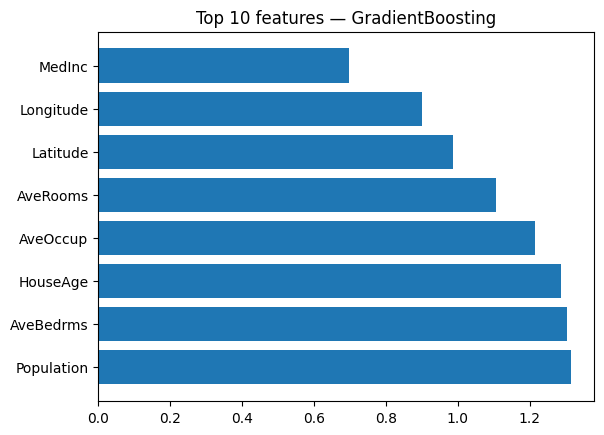

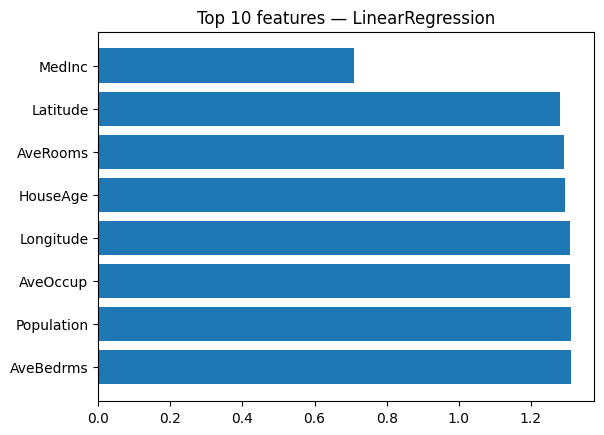

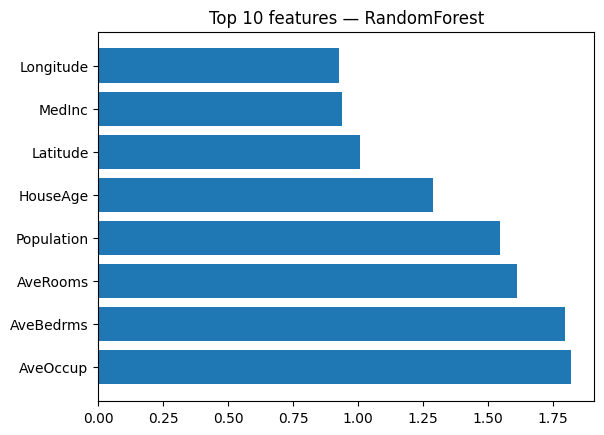

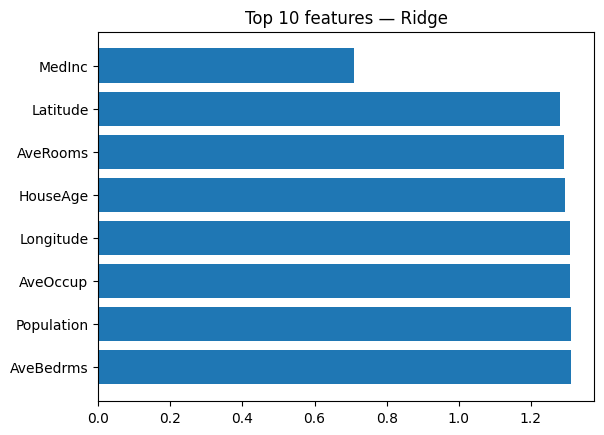

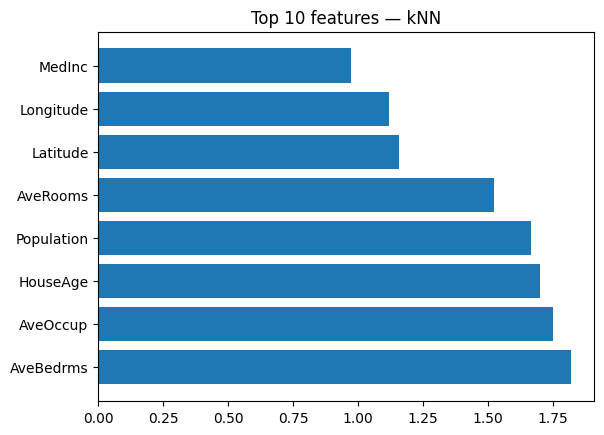

In [16]:
def evaluate_models(df, target_col="LN_IC50"):
    results = []
    y = df[target_col].values
    features = [c for c in df.columns if c != target_col]

    for feat in features:
        X = df[[feat]].values
        Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=RNG)
        for name, model in MODELS.items():
            model.fit(Xtr, ytr)
            yp = model.predict(Xte)
            mse = mean_squared_error(yte, yp)
            results.append({"feature": feat, "model": name, "mse": mse})
    return pd.DataFrame(results)

results = evaluate_models(df)

# Save results
results.to_csv(OUTPUT_DIR / "model_comparison.csv", index=False)

# Plot for each model
for model_name, gdf in results.groupby("model"):
    top = gdf.sort_values("mse").head(TOP_N)
    plt.barh(top["feature"], top["mse"])
    plt.title(f"Top {TOP_N} features — {model_name}")
    plt.gca().invert_yaxis()
    plt.show()
